## Norwich house price prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
data = pd.read_csv('house_prices.csv')

# Convert 'date' column to datetime with specific format
data['date'] = pd.to_datetime(data['date'], format='%b-%y')

# Set 'date' column as index
data.set_index('date', inplace=True)

# Remove the index name
data.index.name = None

# Ensure 'value' column is a numpy array
prices = data['price'].values

# Display the first few rows of the dataframe
data.head()

,house,price,beds,baths,recs,garages,type,pcode,sqm,dg,solar,loft,gsize,poll,noise,age,month
2016-01-01,1,109.019,1,1,1,0,2,3,41.2,0,0,0,1.00,32,67,96,1
2016-01-01,2,314.734,2,1,2,1,3,5,82.8,1,0,1,111.20,13,36,43,1
2016-01-01,3,209.448,2,1,1,0,5,1,65.2,0,0,1,110.25,15,25,93,1
2016-01-01,4,379.322,4,1,3,1,7,7,115.8,0,0,1,282.30,32,128,39,1
2016-01-01,5,260.069,2,1,1,0,6,6,81.3,1,1,1,130.90,36,83,0,1


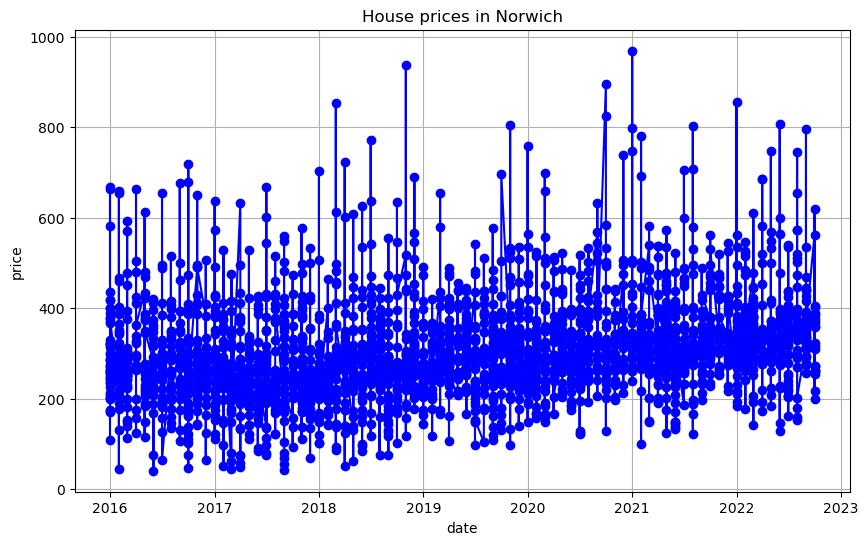

In [3]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data.index.values, prices, marker='o', linestyle='-', color='b')
plt.title('House prices in Norwich')
plt.xlabel('date')
plt.ylabel('price')
plt.grid(True)
plt.show()

In [4]:
data['age2'] = data['age']**2
data['month2'] = data['month']**2
data['month3'] = data['month']**3
data['dg_beds'] = data['beds']*data['dg']
data['loft_recs'] = data['recs']*data['loft']
data['noise2'] = data['noise']**2
data['noise3'] = data['noise']**3

### Data Preprocessing

In [5]:
# Handle missing values if any
data = data.dropna()

# One-hot encode 'type' and 'pcode' and drop the first dummy to avoid dummy variable trap
data = pd.get_dummies(data, columns=['type', 'pcode', 'dg', 'solar', 'loft'], drop_first=True)

# Extracting the dummy variable columns
dummy_columns = [col for col in data.columns if 'type_' in col or 'pcode_' in col or 'solar_' in col or 'dg_' in col 
                 or 'loft_' in col]

# Apply LabelEncoder to each dummy column
label_encoder = LabelEncoder()
for col in dummy_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Features and target
numerical_features = ['baths', 'loft_recs', 'garages', 'sqm', 'dg_beds', 'gsize', 'poll', 'noise', 'age', 'age2', 'month', 
                      'month2', 'month3', 'noise2', 'noise3']

features = numerical_features + dummy_columns

target = 'price'

X = data[features]
y = data[target]


In [6]:
# Normalize only numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Reshape input data for RNN/LSTM [samples, time steps, features]
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [8]:
# Build and train an RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(96, input_shape=(1, X_train.shape[1]), activation='relu'))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [9]:
# Train the RNN model
rnn_history = rnn_model.fit(X_train_reshaped, y_train, epochs=150, batch_size=32, validation_split=0.2, verbose=0)

In [10]:
# Evaluate the RNN model
rnn_predictions = rnn_model.predict(X_test_reshaped)
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_predictions))
rnn_r2 = r2_score(y_test, rnn_predictions)
print(f'RNN RMSE: {rnn_rmse}')
print(f'RNN R²: {rnn_r2}')

19/19 [==============================] - 1s 3ms/step
RNN RMSE: 25.096368915425238
RNN R²: 0.9475191235994538


In [11]:
# Build and train an LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(96, input_shape=(1, X_train.shape[1]), activation='relu'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [12]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_train_reshaped, y_train, epochs=150, batch_size=32, validation_split=0.2, verbose=0)

In [13]:
# Evaluate the LSTM model
lstm_predictions = lstm_model.predict(X_test_reshaped)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)
print(f'LSTM RMSE: {lstm_rmse}')
print(f'LSTM R²: {lstm_r2}')

19/19 [==============================] - 0s 2ms/step
LSTM RMSE: 26.52272210412035
LSTM R²: 0.9413840930566861


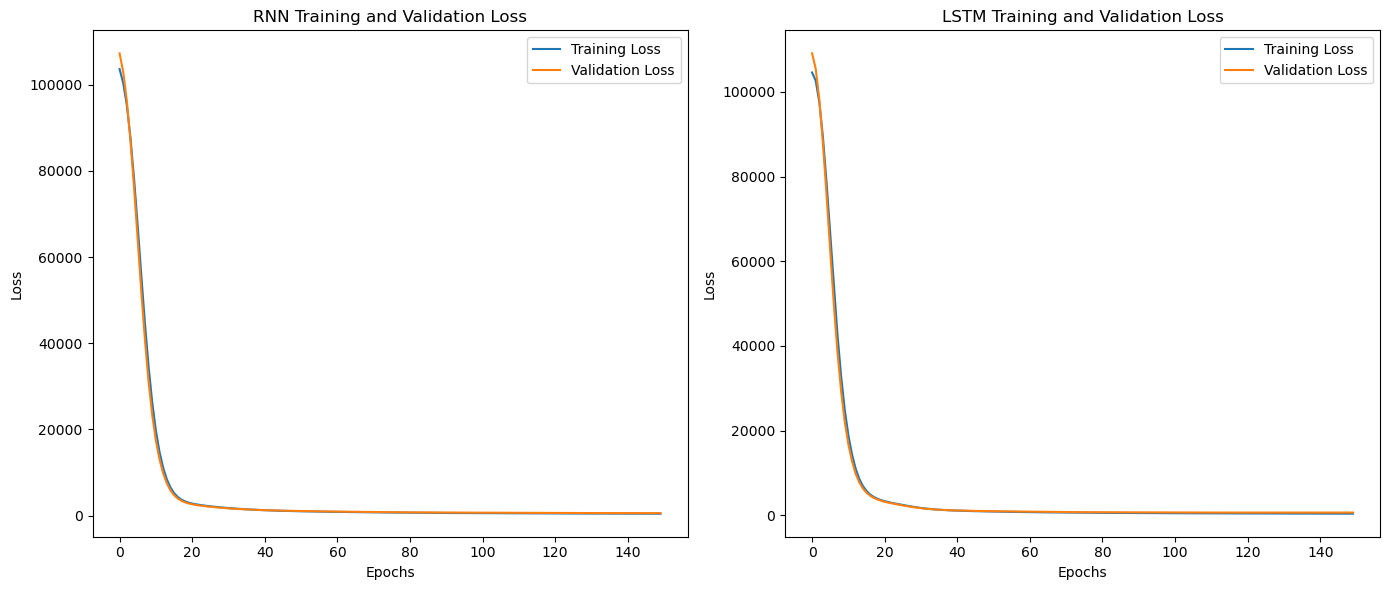

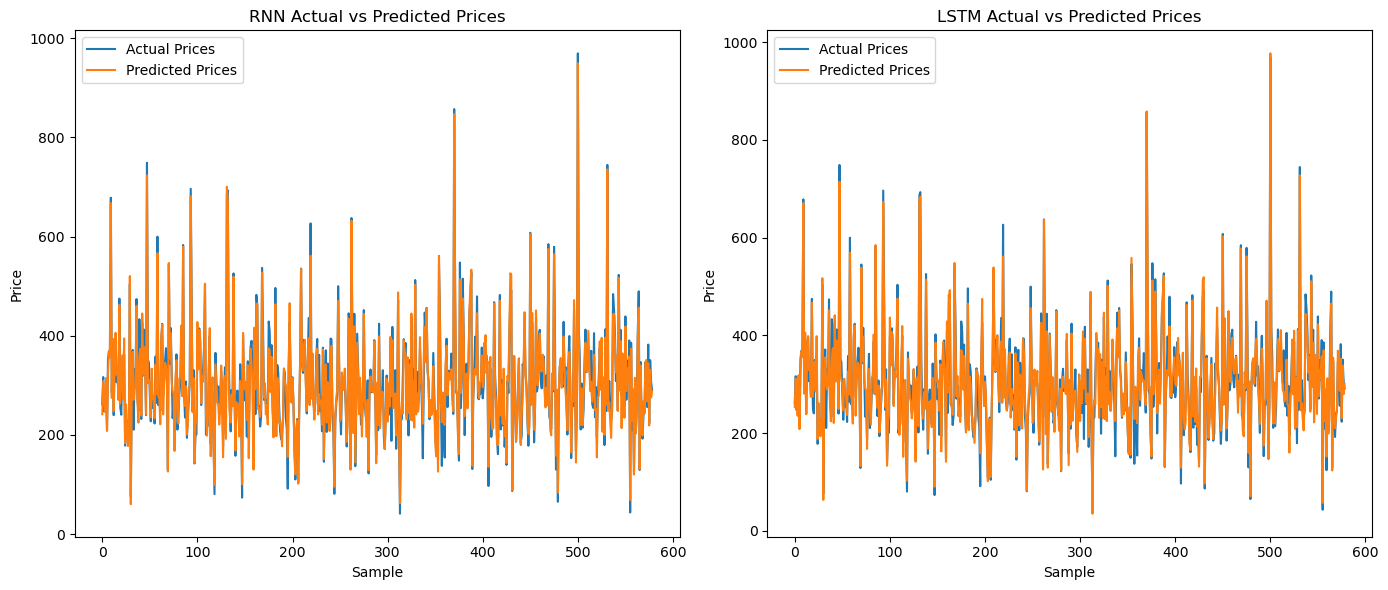

In [14]:
# Plot the loss for both RNN and LSTM
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Plot the actual vs predicted prices for the test data for both RNN and LSTM
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test.values, label='Actual Prices')
plt.plot(rnn_predictions, label='Predicted Prices')
plt.title('RNN Actual vs Predicted Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual Prices')
plt.plot(lstm_predictions, label='Predicted Prices')
plt.title('LSTM Actual vs Predicted Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Create a DataFrame with actual and predicted prices
results_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'RNN Predicted Price': rnn_predictions.flatten(),
    'LSTM Predicted Price': lstm_predictions.flatten()
})

# Save the DataFrame to a CSV file
results_df.to_csv('house_price_predictions.csv', index=False)